In [1]:
from torchview import draw_graph
import graphviz
# graphviz.set_jupyter_format('png')
from torchviz import make_dot, make_dot_from_trace

In [2]:
from cwvae import CWVAE

In [3]:
import numpy as np
import argparse
import os
import ruamel.yaml as yaml
import torch
import pathlib
import sys
from tqdm import tqdm

# from cwvae import build_model
# from loggers.summary import Summary
# from loggers.checkpoint import Checkpoint
from data_loader import *
import tools
from cwvae import CWVAE
from datetime import datetime
import pytz
from prettytable import PrettyTable

/Users/intuinno/anaconda3/envs/cwvae/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/Users/intuinno/anaconda3/envs/cwvae/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please sub

In [4]:
parser = argparse.ArgumentParser()
# args, remaining = parser.parse_known_args()
rootdir = pathlib.Path('~/codegit/cwvae-torch').expanduser()
configs = yaml.safe_load((rootdir / 'configs.yml').read_text())

defaults = {}
for name in ['defaults', 'local_mmnist']:
    defaults.update(configs[name])

for key, value in sorted(defaults.items(), key=lambda x: x[0]):
    arg_type = tools.args_type(value)
    parser.add_argument(f'--{key}', type=arg_type, default=arg_type(value))
# configs = parser.parse_args()

In [5]:
from collections import namedtuple

configs = namedtuple("configs", defaults.keys())(*defaults.values())

In [6]:
model = CWVAE(configs).to(configs.device)

/Users/intuinno/anaconda3/envs/cwvae/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


In [7]:
x = torch.randn(5,16,64,64,1)


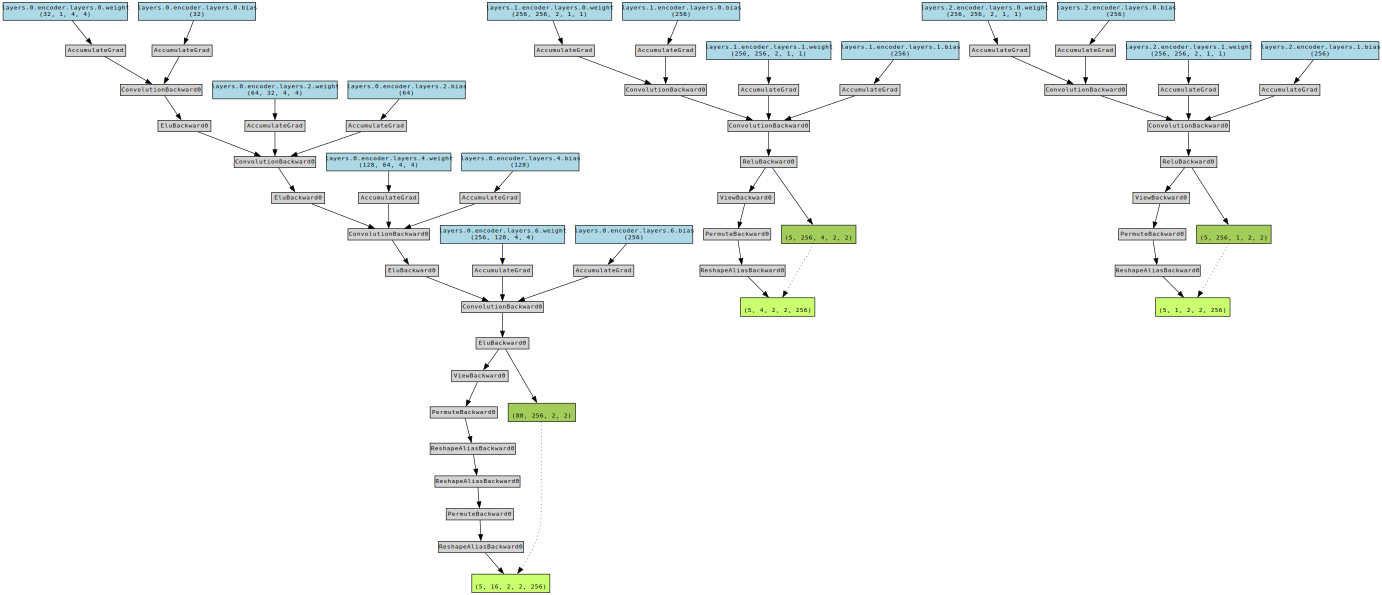

In [14]:
embedding, _ = model.hierarchical_encode(x)
make_dot(tuple((embedding[0], embedding[1], embedding[2])), params=dict(model.named_parameters()))

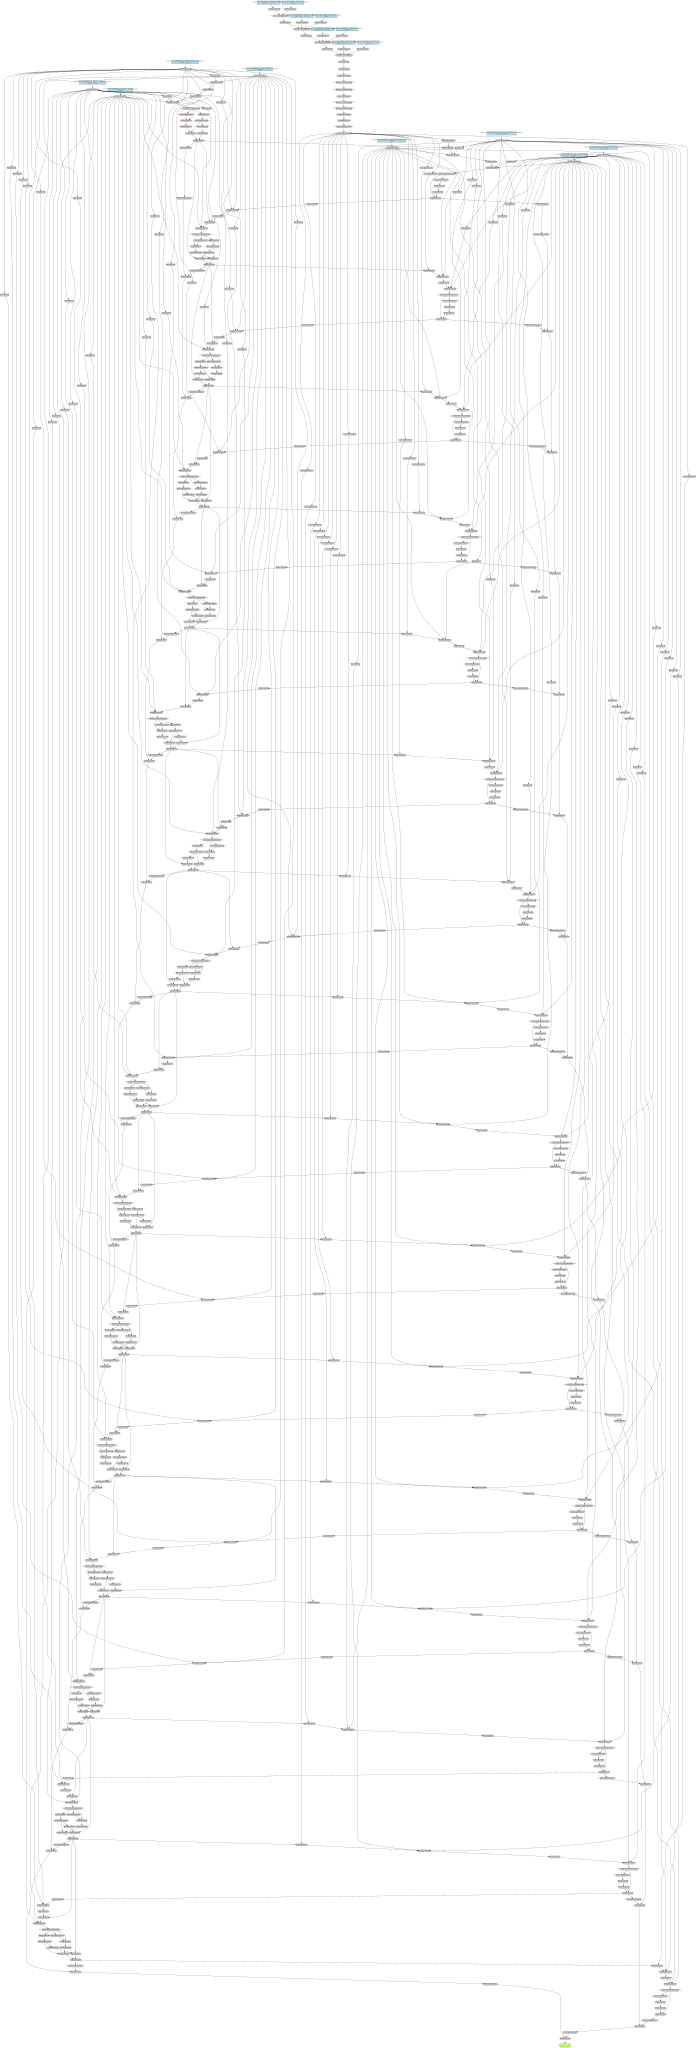

In [38]:
import einops
x = torch.randn(5,16,64,64,1)
embedding, _ = model.hierarchical_encode(x)
inputs = embedding
b, t, h, w, c = inputs[0].shape
        
empty_action = torch.empty(b, t, 0)
actions = empty_action 
    
context = None # None for top level
prior_list, posterior_list = [], []
kl_loss_list, kl_value_list = [], []
feat_list = []

for level in reversed(range(3)):
    inp = einops.rearrange(inputs[level], 'b t h w c -> b t (h w c)')
    post, prior = model.layers[level]['dynamics'].observe(inp, context, actions)
    kl_loss, kl_value = model.layers[level]['dynamics'].kl_loss(
        post, prior, False, 0.8, 1, 1)
    prior_list.insert(0, prior)
    posterior_list.insert(0, post)
    kl_loss_list.insert(0, kl_loss)
    kl_value_list.insert(0, kl_value)
    feat = model.layers[level]['dynamics'].get_feat(post)
    feat_list.insert(0, feat)

    # Build context for lower layer
    stoch = post['stoch']
    context = torch.concat([post['deter'], stoch], dim=-1)
    context = einops.repeat(context, 'b t f -> b (t repeat) f', repeat=4)
    context = context.clone().detach().requires_grad_(False)

make_dot(feat_list[0], params=dict(model.named_parameters()))

In [ ]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [ ]:
count_parameters(model)

In [ ]:
a = model.named_parameters()

In [ ]:
next(a)